In [1]:
%load_ext autoreload
%autoreload 2

In [359]:
from gpt3forchem.data import get_bandgap_data
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_inverse_prediction
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time

from fastcore.helpers import save_pickle
import matplotlib.pyplot as plt
import seaborn as sns 
from rdkit.Chem import AllChem

from rdkit.Contrib.SA_Score.sascorer import calculateScore as calculate_sascore
from rdkit.Chem import Draw
from rdkit import Chem
plt.style.use(['science', 'nature'])

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
data = get_bandgap_data()

In [4]:
train_data_small, test_data_small = train_test_split(
    data, train_size=500, test_size=100, random_state=42
)

In [5]:
smiles_selfies = dict(zip(data["smiles"], data["selfies"]))

In [6]:
data = data.groupby("smiles").agg("mean").reset_index()
data["selfies"] = data["smiles"].map(smiles_selfies)

In [8]:
PROMPT_TEMPLATE_bandgap_inverse = "What is a molecule with a bandgap of {} eV###"
COMPLETION_TEMPLATE_bandgap_inverse = "{}@@@"


def generate_inverse_photoswitch_prompts(
    data: pd.DataFrame, representation: str = "smiles"
) -> pd.DataFrame:
    prompts = []
    completions = []
    smiles = []
    for i, row in data.iterrows():

        prompt = PROMPT_TEMPLATE_bandgap_inverse.format(
            np.round(row["GFN2_HOMO_LUMO_GAP"] * 27.2114, 1)
        )

        completion = COMPLETION_TEMPLATE_bandgap_inverse.format(row[representation])
        prompts.append(prompt)
        completions.append(completion)
        smiles.append(row["smiles"])

    prompts = pd.DataFrame(
        {"prompt": prompts, "completion": completions, "SMILES": smiles}
    )

    return prompts

In [11]:
(
    train_prompts_small_smiles,
    test_prompts_small_smiles,
) = generate_inverse_photoswitch_prompts(
    train_data_small
), generate_inverse_photoswitch_prompts(
    test_data_small
)

In [13]:
def train_inverse_model(train_prompts, representation):

    train_size = len(train_prompts)

    filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
    train_filename = f"run_files/{filename_base}_train_prompts_bandgap_inverse_{representation}_{train_size}.jsonl"

    train_prompts.to_json(train_filename, orient="records", lines=True)

    modelname = fine_tune(train_filename, train_filename, "ada")
    return modelname, train_filename

In [14]:
modelname_small_smiles, train_filename_small_smiles = train_inverse_model(
    train_prompts_small_smiles, "smiles"
)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [15]:
from gpt3forchem.output import test_inverse_bandgap

/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [16]:
def test_inverse_model(
    modelname,
    test_prompts,
    df_train,
    max_tokens: int = 250,
    temperatures=None,
    representation="SMILES",
):
    temperatures = temperatures or [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
    train_smiles = df_train["SMILES"].to_list()
    results = []
    for temperature in temperatures:
        try:
            print(f"Testing temperature {temperature} for {representation}")
            result = test_inverse_bandgap(
                test_prompts,
                modelname,
                train_smiles=train_smiles,
                temperature=temperature,
                max_tokens=max_tokens,
                representation=representation,
            )

            results.append(result)
        except Exception as e:
            print(e)
            pass

    return results

In [17]:
res_500_smiles = test_inverse_model(
    modelname_small_smiles,
    test_prompts_small_smiles,
    train_prompts_small_smiles,
    representation="SMILES",
)

Testing temperature 0 for SMILES


2022-11-27 22:15:59.803 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C(=O)N([H])c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])c([H])c1[H]
2022-11-27 22:15:59.804 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C(=O)N([H])c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])c([H])c1[H]
2022-11-27 22:15:59.826 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 100 samples
2022-11-27 22:15:59.879 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-27 22:16:00.773331: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 22:16:02.143 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frec

Testing temperature 0.25 for SMILES


2022-11-27 22:16:37.239 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C(=O)N([H])c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])c([H])c([H])c1Cl
2022-11-27 22:16:37.243 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C(=O)N([H])c3c([H])c([H])c([H])c([H])c3[H])c([H])c2[H])c([H])c([H])c1Cl
2022-11-27 22:16:37.281 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 76 samples
2022-11-27 22:16:37.340 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-27 22:16:39.339 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (57.71813835865383, 9.69764319338719e-06)
2022-11-27 22:16:39.790 | DEBUG    | gpt3forchem.output:test_inverse_ba

Testing temperature 0.5 for SMILES


2022-11-27 22:17:14.531 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(-c2nc3c([H])c(N4C([H])([H])C([H])([H])N(C([H])([H])[H])C([H])([H])C4([H])[H])c([H])c3n2[H])c([H])c1[H]
2022-11-27 22:17:14.532 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(-c2nc3c([H])c(N4C([H])([H])C([H])([H])N(C([H])([H])[H])C([H])([H])C4([H])[H])c([H])c3n2[H])c([H])c1[H]
2022-11-27 22:17:14.563 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 71 samples
2022-11-27 22:17:14.593 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-27 22:17:16.252 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (37.561995426863696, 0.00054626896950614)
2022-11-27 22:17:16.697 | DEBUG    | gpt3forchem.output:test_inverse_band

Testing temperature 0.75 for SMILES


2022-11-27 22:17:51.531 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1nc(N([H])c2c([H])c([H])c3c(c2[H])nc(N([H])C(=O)N(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])[H])s3c2c([H])c([H])c([H])c([H])c32)c([H])c1[H]
2022-11-27 22:17:51.533 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1nc(N([H])c2c([H])c([H])c3c(c2[H])nc(N([H])C(=O)N(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])[H])s3c2c([H])c([H])c([H])c([H])c32)c([H])c1[H]
2022-11-27 22:17:51.580 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 43 samples
2022-11-27 22:17:51.621 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-27 22:17:53.533 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (37.250014435181924, 0.0005814399335530886)
2022-11-27 22:1

Testing temperature 1.0 for SMILES


2022-11-27 22:18:29.214 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]Oc1c([H])c(C([H])([H])[H])c([H])c(N([H])C(=O)c2c([H])c([H])c(C(F)(F)F)c([H])c2C([H])([H])[H])c1[H]
2022-11-27 22:18:29.215 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]Oc1c([H])c(C([H])([H])[H])c([H])c(N([H])C(=O)c2c([H])c([H])c(C(F)(F)F)c([H])c2C([H])([H])[H])c1[H]
2022-11-27 22:18:29.257 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 18 samples
2022-11-27 22:18:29.285 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-27 22:18:31.028 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (50.68632613408735, 3.957688877697366e-05)
2022-11-27 22:18:31.168 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:970 - Computed KL div score: 0.5249

Testing temperature 1.25 for SMILES


2022-11-27 22:19:06.559 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]C=C#Cc1c([H])c([H])c(C([H])([H])n2c(C([H])([H])S(=O)(=O)c3c([H])cards(C($Figators)F)c(Cl)c3[H])c([H])c(OC([H])([H])[H])c2[H])c1C#N[H]
2022-11-27 22:19:06.561 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]C=C#Cc1c([H])c([H])c(C([H])([H])n2c(C([H])([H])S(=O)(=O)c3c([H])cards(C($Figators)F)c(Cl)c3[H])c([H])c(OC([H])([H])[H])c2[H])c1C#N[H]
2022-11-27 22:19:06.609 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 9 samples
2022-11-27 22:19:06.651 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-27 22:19:08.219 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (64.34800037696363, 2.5751569470566044e-06)
2022-11-27 22:19:08.307 | DEBUG    | gpt3f

Testing temperature 1.5 for SMILES


2022-11-27 22:19:44.011 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [hvin]),n(-nc(-c2c([H])n(-Ct1c([H])c([H])c(-c4c([H])c([H])ncmedium5n(N5C([H])([H])C([H])([H])C5([H])C([H])([H])C([H])([H])C6
2022-11-27 22:19:44.012 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [hvin]),n(-nc(-c2c([H])n(-Ct1c([H])c([H])c(-c4c([H])c([H])ncmedium5n(N5C([H])([H])C([H])([H])C5([H])C([H])([H])C([H])([H])C6
2022-11-27 22:19:44.054 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 3 samples
2022-11-27 22:19:44.082 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-27 22:19:45.991 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (90.77580457366079, 1.304108713424753e-08)
2022-11-27 22:19:46.026 | DEBUG    | gpt3forchem.output:test_invers

In [19]:
timestamp = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())

In [155]:
save_pickle(f"run_files/{timestamp}-res_500_smiles.pkl", res_500_smiles)

In [30]:
smiles_500_sets = []

for res in res_500_smiles:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_500_sets.append(result)

for res in smiles_500_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}500_smiles_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

For the ground truth, we need to swtich to running on the server


In [23]:
from natsort import natsorted

In [119]:
def get_xtb_results(filename, results):
    outputs = []
    for res in results:
        temp = res["temperature"]
        with open(f'for_xtb_opt/{filename}_{temp}_gaps.txt', 'r') as f:
            gaps_ = f.readlines()
            if not gaps_: print(f"No results found for {temp}"); continue
            gaps = []
            for _gap in gaps_:
                name, gap = _gap.split()
                gaps.append((int(name.split("/")[-1]), float(gap) if gap !='None' else np.nan))

        predicted, true = [], []

        for i, g in gaps:
            predicted.append(g)
            true.append(res["expected"][i])

        true, predicted = np.array(true), np.array(predicted)

        not_nan_mask = ~np.isnan(predicted)
        outputs.append(
            {
                'predicted': predicted,
                'true': true,
                'temperature': temp,
                 'r2_score': r2_score(true[not_nan_mask], predicted[not_nan_mask]),
                'mae': mean_absolute_error(true[not_nan_mask], predicted[not_nan_mask]),
            }
        )
    return outputs

In [156]:
smiles_small_xtb_results = get_xtb_results('2022-11-27-22-29-43500_smiles', smiles_500_sets)
save_pickle('run_files/2022-11-27-22-29-43500_smiles_xtb_results.pkl', smiles_small_xtb_results)

#### Now use SELFIES


In [109]:
train_prompts_selfies, test_prompts_selfies = generate_inverse_photoswitch_prompts(
    train_data_small, "selfies"
), generate_inverse_photoswitch_prompts(test_data_small, "selfies")

In [112]:
modelname_500_selfies, train_filename_500_selfies = train_inverse_model(
    train_prompts_selfies, "selfies"
)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [137]:
res_500_seflies = test_inverse_model(
    modelname_500_selfies,
    test_prompts_selfies,
    train_prompts_selfies,
    representation="selfies",
    max_tokens=1600,
    temperatures=[0]
)

Testing temperature 0 for selfies


2022-11-28 09:42:25.264 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch2][Branch2][=Branch2][C][Branch1][C][H][Branch1][C][H][N][Branch1][C][H][C][=Branch1][C][=O][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][

In [122]:
save_pickle(f"run_files/{timestamp}-res_500_selfies.pkl", res_500_seflies)

In [134]:
res_500_seflies[0]['predictions']

array(['[H][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch2][Branch2][=Branch2][C][Branch1][C][H][Branch1][C][H][N][Branch1][C][H][C][=Branch1][C][=O][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][',
       '[H][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch2][Branch2][=Branch2][C][Branch1][C][H][Branch1][C][H][N][Branch1][C][H][C][=Branch1][C][=O][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][C][H][Branch1][C][H][C][Branch1][',
       '[H][C][=C][Branch1][C][H][C][Branch1][C][H][=C][Branch2][B

In [124]:
import selfies as sf

In [132]:
selfies_500_sets = []

for res in res_500_seflies:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    print(res["predictions"][res["valid_smiles"]])
    result["selfies"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    print(result["selfies"])
    result['smiles'] = [sf.decoder(x) for x in result['selfies']]
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['selfies']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    selfies_500_sets.append(result)

for res in selfies_500_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}500_selfies_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

[]
set()
['[H]C=NC(N([H])C(=O)N([H])C1=C([H])C([H])=C([H])C([H])=C1C([H])[H])[H]'
 '[H]C=NC(C1=C([H])C([H])=C([H])C([H])=C1[H])[H]'
 '[H]C=C([H])CC=C([H])C([H])=C(C1=C([H])C([H])=C([H])C([H])=C1[H])C[H]'
 '[H]OC(=O)C=C([H])C([H])=CC1=C([H])C([H])=C([H])C([H])=C1[H]']
{'[H]C=NC(N([H])C(=O)N([H])C1=C([H])C([H])=C([H])C([H])=C1C([H])[H])[H]', '[H]C=NC(C1=C([H])C([H])=C([H])C([H])=C1[H])[H]', '[H]C=C([H])CC=C([H])C([H])=C(C1=C([H])C([H])=C([H])C([H])=C1[H])C[H]', '[H]OC(=O)C=C([H])C([H])=CC1=C([H])C([H])=C([H])C([H])=C1[H]'}


DecoderError: invalid symbol 'C=NC(N([H]'
	SELFIES: [H]C=NC(N([H])C(=O)N([H])C1=C([H])C([H])=C([H])C([H])=C1C([H])[H])[H]

## Larger training set


In [138]:
train_large, test_large = train_test_split(
    data, train_size=1000, test_size=100, random_state=42
)

In [139]:
(
    train_prompts_large_smiles,
    test_prompts_large_smiles,
) = generate_inverse_photoswitch_prompts(
    train_large, "smiles"
), generate_inverse_photoswitch_prompts(
    test_large, "smiles"
)

(
    train_prompts_large_selfies,
    test_prompts_large_selfies,
) = generate_inverse_photoswitch_prompts(
    train_large, "selfies"
), generate_inverse_photoswitch_prompts(
    test_large, "selfies"
)

In [140]:
modelname_1000_smiles, train_filename_1000_smiles = train_inverse_model(
    train_prompts_large_smiles, "smiles"
)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [141]:
res_1000_smiles = test_inverse_model(
    modelname_1000_smiles,
    test_prompts_large_smiles,
    train_prompts_large_smiles,
    representation="SMILES",
)

Testing temperature 0 for SMILES


2022-11-28 10:15:23.805 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H
2022-11-28 10:15:23.806 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H
2022-11-28 10:15:23.831 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Fr

Testing temperature 0.25 for SMILES


2022-11-28 10:15:58.877 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([
2022-11-28 10:15:58.879 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([
2022-11-28 10:15:58.913 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating 

Testing temperature 0.5 for SMILES


2022-11-28 10:16:35.774 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-11-28 10:16:35.775 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])[H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-11-28 10:16:35.812 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 57 samples
2022-11-28 10:16:35.884 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 10:16:37.279 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (37.1945706780868

Testing temperature 0.75 for SMILES


2022-11-28 10:17:12.450 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])[C@@]2([H])C([H])([H])N([H])C(=O)C([H])([H])N(C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])c3oc4c([H])c([H])c([H])c([H])c4c3=O)C([H])([H])C2([H])[H])c([H])c1[H]
2022-11-28 10:17:12.451 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]Oc1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])[C@@]2([H])C([H])([H])N([H])C(=O)C([H])([H])N(C([H])([H])C([H])([H])N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])c3oc4c([H])c([H])c([H])c([H])c4c3=O)C([H])([H])C2([H])[H])c([H])c1[H]
2022-11-28 10:17:12.496 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 56 samples
2022-11-28 10:17:12.533 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.

Testing temperature 1.0 for SMILES


2022-11-28 10:17:49.717 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1nc([C@]2([H])C([H])([H])C([H])([H])N(C([H])([H])c3nc([H])c([N+](=O)[O-])c([H])c3[H])C([H])([H])C([H])([H])S2([H])[H])nc([H])c1OC([H])([H])C([H])([H])C([H])([H])C2([H])[H]
2022-11-28 10:17:49.718 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1nc([C@]2([H])C([H])([H])C([H])([H])N(C([H])([H])c3nc([H])c([N+](=O)[O-])c([H])c3[H])C([H])([H])C([H])([H])S2([H])[H])nc([H])c1OC([H])([H])C([H])([H])C([H])([H])C2([H])[H]
2022-11-28 10:17:49.768 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 28 samples
2022-11-28 10:17:49.796 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 10:17:51.123 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (39.452

Testing temperature 1.25 for SMILES


2022-11-28 10:18:27.444 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1sc(-c2oc3c([H])c([H])c([H])c([H])c3c2n2C([H])([H])C([H])([H])O3)c([H])c(C(=O)OC([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c1[H]
2022-11-28 10:18:27.445 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1sc(-c2oc3c([H])c([H])c([H])c([H])c3c2n2C([H])([H])C([H])([H])O3)c([H])c(C(=O)OC([H])([H])c2c([H])c([H])c([H])c([H])c2[H])c1[H]
2022-11-28 10:18:27.472 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 7 samples
2022-11-28 10:18:27.515 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 10:18:33.032 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (65.18249915247344, 2.1793152620181415e-06)
2022-11-28 10:18:33.098 | DEBUG    | gpt3forchem.out

Testing temperature 1.5 for SMILES


2022-11-28 10:19:11.079 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]ON1C(=O)c2sc(=o)c([H])c([H])c2C1=O
2022-11-28 10:19:11.079 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]ON1C(=O)c2sc(=o)c([H])c([H])c2C1=O
2022-11-28 10:19:11.103 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 3 samples
2022-11-28 10:19:11.176 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 10:19:17.189 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (100.93881271193972, 1.708307807952628e-09)
2022-11-28 10:19:17.216 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:970 - Computed KL div score: 0.5275411763797172


In [143]:
save_pickle(f"run_files/{timestamp}-res_1000_smiles.pkl", res_1000_smiles)

In [144]:
smiles_1000_sets = []

for res in res_1000_smiles:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_1000_sets.append(result)

for res in smiles_1000_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}1000_smiles_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [157]:
smiles_large_xtb_results = get_xtb_results('2022-11-27-22-29-431000_smiles', smiles_1000_sets)
save_pickle('run_files/2022-11-27-22-29-431000_smiles_xtb_results.pkl', smiles_large_xtb_results)

No results found for 0


## Very large

In [149]:
train_very_large, test_very_large = train_test_split(
    data, train_size=5000, test_size=100, random_state=42
)

In [150]:
(
    train_prompts_very_large_smiles,
    test_prompts_very_large_smiles,
) = generate_inverse_photoswitch_prompts(
    train_very_large, "smiles"
), generate_inverse_photoswitch_prompts(
    test_very_large, "smiles"
)

(
    train_prompts_very_large_selfies,
    test_prompts_very_large_selfies,
) = generate_inverse_photoswitch_prompts(
    train_very_large, "selfies"
), generate_inverse_photoswitch_prompts(
    test_very_large, "selfies"
)

In [151]:
modelname_5000_smiles, train_filename_5000_smiles = train_inverse_model(
    train_prompts_very_large_smiles, "smiles"
)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [152]:
res_5000_smiles = test_inverse_model(
    modelname_5000_smiles,
    test_prompts_very_large_smiles,
    train_prompts_very_large_smiles,
    representation="SMILES",
)

Testing temperature 0 for SMILES


2022-11-28 12:55:08.387 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)N([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-28 12:55:08.387 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)N([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-28 12:55:08.441 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 49 samples
2022-11-28 12:55:08.530 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 12:55:10.229 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (68.56659011537226, 1.1075967022091465e-06)
2022-11-28 12:55:10.473 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:970 - Computed KL div score: 0.070

Testing temperature 0.25 for SMILES


2022-11-28 12:55:45.286 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H]
2022-11-28 12:55:45.287 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H]
2022-11-28 12:55:45.328 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating 

Testing temperature 0.5 for SMILES


2022-11-28 12:56:22.712 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1nc([H])c([H])c(-c2c([H])c([H])c(C(=O)N([H])[C@]([H])(C(=O)N3C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])c3c([H])c([H])c([H])c([H])c3C([H])([H])[H])c([H])c2[H])c1[H]
2022-11-28 12:56:22.716 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1nc([H])c([H])c(-c2c([H])c([H])c(C(=O)N([H])[C@]([H])(C(=O)N3C([H])([H])C([H])([H])C([H])([H])C([H])([H])C3([H])[H])C([H])([H])c3c([H])c([H])c([H])c([H])c3C([H])([H])[H])c([H])c2[H])c1[H]
2022-11-28 12:56:22.742 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 79 samples
2022-11-28 12:56:22.817 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 12:56:35.783 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 -

Testing temperature 0.75 for SMILES


2022-11-28 12:57:11.278 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(S(=O)(=O)N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])[H])c(OC([H])([H])[H])c1[H]
2022-11-28 12:57:11.278 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(S(=O)(=O)N([H])C(=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])N([H])[H])c(OC([H])([H])[H])c1[H]
2022-11-28 12:57:11.308 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 78 samples
2022-11-28 12:57:11.364 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 12:57:39.811 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (26.08972613798312, 0.005418451380042558)
2022-11-28 12:57:40.382 | DEBUG    | gpt3forchem.output:test_

Testing temperature 1.0 for SMILES


2022-11-28 12:58:15.636 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]OC(=O)[C@@]([H])(N([H])S(=O)(=O)c1c([H])c([H])c([H])c(C([H])([H])N2c3c4c([H])c([H])c([H])c([H])c4n(C([H])(C([H])([H])[H])C([H])([H])[H])c3c(=O)c2[H])c1[H])C([H])([H])c1c([H])c([H])c(OC([H])([H])[H])c(C([H])([H])[H])c1[H]
2022-11-28 12:58:15.637 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]OC(=O)[C@@]([H])(N([H])S(=O)(=O)c1c([H])c([H])c([H])c(C([H])([H])N2c3c4c([H])c([H])c([H])c([H])c4n(C([H])(C([H])([H])[H])C([H])([H])[H])c3c(=O)c2[H])c1[H])C([H])([H])c1c([H])c([H])c(OC([H])([H])[H])c(C([H])([H])[H])c1[H]
2022-11-28 12:58:15.691 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 64 samples
2022-11-28 12:58:15.748 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 12:58:1

Testing temperature 1.25 for SMILES


2022-11-28 12:58:53.863 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c2nsc(N([H])C([H])([H])C#N)c2c1[H]
2022-11-28 12:58:53.864 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c2nsc(N([H])C([H])([H])C#N)c2c1[H]
2022-11-28 12:58:53.911 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 31 samples
2022-11-28 12:58:53.987 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 12:58:55.463 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (41.40899478572808, 0.0002530815074856264)
2022-11-28 12:58:55.649 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:970 - Computed KL div score: 0.6509537496104156


Testing temperature 1.5 for SMILES


2022-11-28 12:59:31.561 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]OP(C(=O)N1c2nn(-c3c([H])c([H])c([H])c(OC([H])([H])[H])c3C#N)[c2N(C([H])([H])c2nc3c([H])c([H])c(#N)c([H])c3u2)SC([H])([H])[C@@]1(C(=O)N([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H]
2022-11-28 12:59:31.561 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]OP(C(=O)N1c2nn(-c3c([H])c([H])c([H])c(OC([H])([H])[H])c3C#N)[c2N(C([H])([H])c2nc3c([H])c([H])c(#N)c([H])c3u2)SC([H])([H])[C@@]1(C(=O)N([H])[H])C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H]
2022-11-28 12:59:31.587 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 2 samples
2022-11-28 12:59:31.659 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-28 12:59:34.037 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:95

In [153]:
save_pickle(f"run_files/{timestamp}-res_5000_smiles.pkl", res_5000_smiles)

In [154]:
smiles_5000_sets = []

for res in res_5000_smiles:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_5000_sets.append(result)

for res in smiles_5000_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}5000_smiles_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [164]:
smiles_very_large_xtb_results = get_xtb_results('2022-11-27-22-29-435000_smiles', smiles_5000_sets)
save_pickle('run_files/2022-11-27-22-29-435000_smiles_xtb_results.pkl', smiles_very_large_xtb_results)

## Very very large dataset

In [161]:
train_very_very_large, test_very_very_large = train_test_split(
    data, train_size=50_000, test_size=100, random_state=42
)

In [162]:
(
    train_prompts_very_very_large_smiles,
    test_prompts_very_very_large_smiles,
) = generate_inverse_photoswitch_prompts(
    train_very_very_large, "smiles"
), generate_inverse_photoswitch_prompts(
    test_very_very_large, "smiles"
)

(
    train_prompts_very_very_large_selfies,
    test_prompts_very_very_large_selfies,
) = generate_inverse_photoswitch_prompts(
    train_very_very_large, "selfies"
), generate_inverse_photoswitch_prompts(
    test_very_very_large, "selfies"
)

In [163]:
modelname_50000_smiles, train_filename_50000_smiles = train_inverse_model(
    train_prompts_very_very_large_smiles, "smiles"
)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [397]:
modelname_50000_smiles

'ada:ft-lsmoepfl-2022-11-28-16-40-07'

In [398]:
train_prompts_very_very_large_smiles.to_csv('run_files/2022-11-27-22-29-43500000_smiles_train.csv')

In [166]:
res_50000_smiles = test_inverse_model(
    modelname_50000_smiles,
    test_prompts_very_very_large_smiles,
    train_prompts_very_very_large_smiles,
    representation="SMILES",
)

Testing temperature 0 for SMILES


2022-11-29 09:20:55.976 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])(N([H])C(=O)N([H])c3c([H])c([H])c([H])c(C(F)(F)F)c3[H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-11-29 09:20:55.978 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])(N([H])C(=O)N([H])c3c([H])c([H])c([H])c(C(F)(F)F)c3[H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-11-29 09:20:56.114 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 64 samples
2022-11-29 09:20:56.285 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-29 09:21:03.507 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (75.83256185385164, 2.589806804800088e-07)
2022-11-29 09:21:0

Testing temperature 0.25 for SMILES


2022-11-29 09:21:38.689 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c2[H])c([
2022-11-29 09:21:38.690 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c2[H])c([
2022-11-29 09:21:38.791 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Fr

Testing temperature 0.5 for SMILES


2022-11-29 09:22:16.171 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(-c2c([H])c([H])c3c(c2[H])c2c(n3[H])C([H])([H])C([H])([H])N(C([H])([H])[H])C2([H])[H])c([H])c1[H]
2022-11-29 09:22:16.174 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(-c2c([H])c([H])c3c(c2[H])c2c(n3[H])C([H])([H])C([H])([H])N(C([H])([H])[H])C2([H])[H])c([H])c1[H]
2022-11-29 09:22:16.361 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 87 samples
2022-11-29 09:22:16.453 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-29 09:22:22.651 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (27.019162005287072, 0.004499304718886422)
2022-11-29 09:22:23.281 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:970 - C

Testing temperature 0.75 for SMILES


2022-11-29 09:22:58.110 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])OC(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[H])C([H])([H])C([H])([H])C(=O)N([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[H])C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])C([H])([H])C([H])([H])SC([H])([H])[H])C([H])([H])c2c([H])n([H])c3c([H])c([H])c([H])c([H
2022-11-29 09:22:58.118 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])OC(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[H])C([H])([H])C([H])([H])C(=O)N([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[H])C([H])([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])C([H])([H])C([H])([H])SC([H])([H])[H])C([H])([H])c2c([H])n([H])c3c([H])c([H])c([H])c([H
2022-11-29 09:22:58.235 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distan

Testing temperature 1.0 for SMILES


2022-11-29 09:23:39.575 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])OC([H])([H])C([H])([H])n2c([H])nnc2[C@]([H])(c2c(C(=O)OC([H])([H])[H])n([H])c3c([H])c([H])c(Cl)c([H])c23)C([H])([H])[H])c([H])c1[H]
2022-11-29 09:23:39.575 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])OC([H])([H])C([H])([H])n2c([H])nnc2[C@]([H])(c2c(C(=O)OC([H])([H])[H])n([H])c3c([H])c([H])c(Cl)c([H])c23)C([H])([H])[H])c([H])c1[H]
2022-11-29 09:23:39.677 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 79 samples
2022-11-29 09:23:39.759 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-29 09:23:45.804 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:959 - Computed frechet score: (23.990252549068067, 0.008245806508

Testing temperature 1.25 for SMILES


2022-11-29 09:24:21.459 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]c1c([H])c(C(=C2C([H])([H])C([H])([H])C3(N([H])C(=O)N(C([H])([H])C([H])([H])[H])C3([H])[H])C([H])([H])C2([H])[H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c([H])c1N(C([H])([H])C1([H])C([H])([H])C1([H])[H])C([H])([H])C([H])([H])N(C([H])([H])C1([H])C([H])([H])C([H])([H])OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C1([H])[H])
2022-11-29 09:24:21.459 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]c1c([H])c(C(=C2C([H])([H])C([H])([H])C3(N([H])C(=O)N(C([H])([H])C([H])([H])[H])C3([H])[H])C([H])([H])C2([H])[H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c([H])c1N(C([H])([H])C1([H])C([H])([H])C1([H])[H])C([H])([H])C([H])([H])N(C([H])([H])C1([H])C([H])([H])C([H])([H])OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C1([H])[H])
2022-11-29 09:24:21.533 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNe

Testing temperature 1.5 for SMILES


2022-11-29 09:24:59.088 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:928 - Got predictions, example: [H]SC([H])([H])[C@@]1([H])OC(=O)N([C@]([H])(C(=O)OC([H])([H])[H])C([H])([H])SC([H])(NC([H])(Y([H])[H])H])C2=NC([H])(C([H])([H])N3C([H])([H])C([H])([H])N(C([H])([H])[C@@]([H])(c4c([H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c4[H])n
2022-11-29 09:24:59.091 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:939 - Loaded predictions. Example: [H]SC([H])([H])[C@@]1([H])OC(=O)N([C@]([H])(C(=O)OC([H])([H])[H])C([H])([H])SC([H])(NC([H])(Y([H])[H])H])C2=NC([H])(C([H])([H])N3C([H])([H])C([H])([H])N(C([H])([H])[C@@]([H])(c4c([H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c4[H])n
2022-11-29 09:24:59.201 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:950 - Calculating Frechet ChemNet distance for 21 samples
2022-11-29 09:24:59.361 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.

In [167]:
smiles_50000_sets = []

for res in res_50000_smiles:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_50000_sets.append(result)

for res in smiles_50000_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}50000_smiles_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [169]:
smiles_very_very_large_xtb_results = get_xtb_results('2022-11-27-22-29-4350000_smiles', smiles_50000_sets)
save_pickle('run_files/2022-11-27-22-29-4350000_smiles_xtb_results.pkl', smiles_very_very_large_xtb_results)

### Plot the different property distributions we obtained

In [223]:
smiles_large_xtb_results[1]

{'predicted': array([2.82764878, 3.51907362, 2.3008173 , 3.3957338 , 3.428438  ,
        2.2879816 , 2.32295267, 2.83726935, 3.25523997, 4.21052793,
        2.96677789, 2.28320052, 2.61581535, 2.7351771 , 3.64296891,
        3.35145769, 3.20662711, 3.89318773, 2.96801203, 2.62519708,
        2.62407338, 1.53467131, 3.44472667, 2.819152  , 2.73786441,
        2.54047645, 2.27874637, 2.45176937, 2.77603499, 2.41388735,
        2.56486119, 3.21656629, 2.55595735, 1.54190082, 3.77373414,
        2.84683636, 4.58089861, 3.28097841, 1.87360604, 3.04955484,
        3.20055845, 2.74091163, 2.70913726, 3.6571444 , 2.29942284,
        3.62420437, 3.87601197, 2.49010039, 3.13229366, 2.69192904,
        4.90236776, 3.37656932, 2.53820638, 3.7591203 , 3.09442013,
        3.46471883, 2.20979905]),
 'true': array([2.8, 1.8, 3.4, 2.4, 2.3, 2.1, 2.2, 2.3, 3. , 1.4, 2.1, 2.8, 2.4,
        1.7, 1.7, 1.7, 2.6, 2.1, 2.4, 2. , 2. , 0.9, 3.6, 2.4, 2.7, 2.3,
        2.4, 2.1, 2.2, 3. , 2.4, 3.4, 2.5, 2.4, 2. 

In [178]:
plt.set_loglevel("info") 

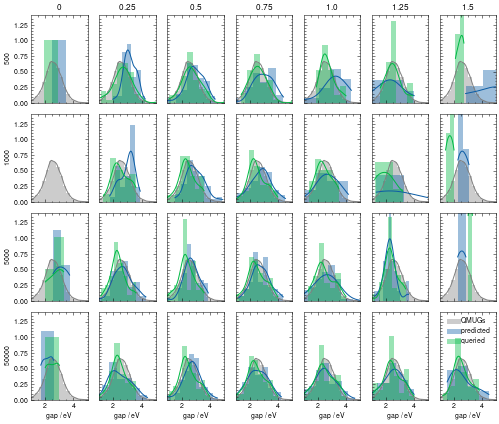

In [247]:
fig, ax = plt.subplots(4,7, figsize=(7,6), sharex='all', sharey='all')

temperatures = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
train_sizes = [500, 1000, 5000, 50000]


for i in range(4):
    for j in range(7):
        sns.distplot(data['GFN2_HOMO_LUMO_GAP']* 27.2114, ax=ax[i,j], color='gray', label='QMUGs')

for i in range(7):
    sns.distplot(smiles_small_xtb_results[i]['predicted'], ax=ax[0][i], kde_kws={"cut":0}, label='predicted')
    sns.distplot(smiles_small_xtb_results[i]['true'], ax=ax[0][i], kde_kws={"cut":0}, label='queried')  
    assert temperatures[i] == smiles_small_xtb_results[i]['temperature'], f"{temperatures[i]} != {smiles_small_xtb_results[i]['temperature']}"


for i in range(7):
    offset = 1
    if i > (6 - offset):
        break
    sns.distplot(smiles_large_xtb_results[i]['predicted'], ax=ax[1][i+offset], kde_kws={"cut":0})
    sns.distplot(smiles_large_xtb_results[i]['true'], ax=ax[1][i+offset], kde_kws={"cut":0})
    assert temperatures[i+offset] == smiles_large_xtb_results[i]['temperature'], f"Temperature mismatch: {temperatures[i+offset]} != {smiles_large_xtb_results[i]['temperature']}"

for i in range(7):
    sns.distplot(smiles_very_large_xtb_results[i]['predicted'], ax=ax[2][i], kde_kws={"cut":0}, label='predicted')
    sns.distplot(smiles_very_large_xtb_results[i]['true'], ax=ax[2][i], kde_kws={"cut":0}, label='queried')  
    assert temperatures[i] == smiles_very_large_xtb_results[i]['temperature'], f"{temperatures[i]} != {smiles_very_large_xtb_results[i]['temperature']}"

for i in range(7):
    sns.distplot(smiles_very_very_large_xtb_results[i]['predicted'], ax=ax[3][i], kde_kws={"cut":0}, label='predicted')
    sns.distplot(smiles_very_very_large_xtb_results[i]['true'], ax=ax[3][i], kde_kws={"cut":0}, label='queried')  
    assert temperatures[i] == smiles_very_very_large_xtb_results[i]['temperature'], f"{temperatures[i]} != {smiles_very_very_large_xtb_results[i]['temperature']}"

ax[0][0].set_ylim(0, 1.4)
ax[0][0].set_xlim(1, 5)

for i, temp in enumerate(temperatures):
    ax[0][i].set_title(f"{temp}")

for i in range(len(temperatures)):
    ax[-1][i].set_xlabel("gap / eV")

for i, train_size in enumerate(train_sizes):
    ax[i][0].set_ylabel(f"{train_size}")

fig.show()

ax[-1,-1].legend(handletextpad=0)
fig.tight_layout()

fig.savefig('20221130_predicted_gap_distributions_random_sampling.pdf', bbox_inches='tight')

### Make plots about the diversity of the generated molecules

In [374]:
def get_sa_scores(smiles):
    sa_scores = []
    for smiles in smiles:
        try:
            mol = Chem.MolFromSmiles(smiles)
            sa_scores.append(calculate_sascore(mol))
        except: 
            pass
    return sa_scores

In [375]:
diversity_metrics = []

for res in res_50000_smiles: 
    sa_scores = get_sa_scores(res['predictions'][res['valid_smiles']])
    metrics = {
        'temperature': res['meta']['temperature'],
        'kl_divergence': res['kl_divergence'],
        'unique_smiles': res['unique_smiles'],
        'fcd': res['frechet_chemnet'][0],
        'valid_smiles': res['fractions_valid_smiles'], 
        'smiles_in_train': res['fractions_smiles_in_train'],
        'train_size': 50_000,
        'mean_sa_score': np.mean(sa_scores),
    }

    diversity_metrics.append(metrics)

for res in res_5000_smiles: 
    sa_scores = get_sa_scores(res['predictions'][res['valid_smiles']])
    metrics = {
        'temperature': res['meta']['temperature'],
        'kl_divergence': res['kl_divergence'],
        'unique_smiles': res['unique_smiles'],
        'fcd': res['frechet_chemnet'][0],
        'valid_smiles': res['fractions_valid_smiles'], 
        'smiles_in_train': res['fractions_smiles_in_train'],
        'train_size': 5_000,
         'mean_sa_score': np.mean(sa_scores),
    }

    diversity_metrics.append(metrics)

for res in res_1000_smiles: 

    sa_scores = get_sa_scores(res['predictions'][res['valid_smiles']])
    metrics = {
        'temperature': res['meta']['temperature'],
        'kl_divergence': res['kl_divergence'],
        'unique_smiles': res['unique_smiles'],
        'fcd': res['frechet_chemnet'][0] if not isinstance(res['frechet_chemnet'], float) else np.nan,
        'valid_smiles': res['fractions_valid_smiles'], 
        'smiles_in_train': res['fractions_smiles_in_train'],
        'train_size': 1_000,
         'mean_sa_score': np.mean(sa_scores),
    }

    diversity_metrics.append(metrics)

for res in res_500_smiles: 
    sa_scores = get_sa_scores(res['predictions'][res['valid_smiles']])
    metrics = {
        'temperature': res['meta']['temperature'],
        'kl_divergence': res['kl_divergence'],
        'unique_smiles': res['unique_smiles'],
        'fcd': res['frechet_chemnet'][0] if not isinstance(res['frechet_chemnet'], float) else np.nan,
        'valid_smiles': res['fractions_valid_smiles'], 
        'smiles_in_train': res['fractions_smiles_in_train'],
        'train_size': 500,
         'mean_sa_score': np.mean(sa_scores),
    }

    diversity_metrics.append(metrics)

In [376]:
diversity_metrics = pd.DataFrame(diversity_metrics)

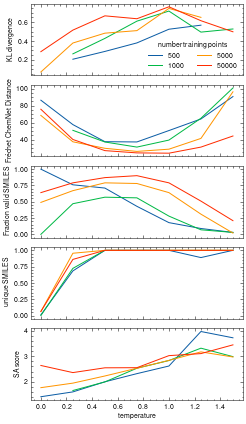

In [380]:
fig, ax = plt.subplots(5,1, sharex='all', figsize=(3.5, 6))

for train_size in [500, 1000, 5000, 50_000]:
    subset = diversity_metrics[diversity_metrics['train_size'] == train_size]
    ax[0].plot(subset['temperature'], subset['kl_divergence'], label=train_size)


for train_size in [500, 1000, 5000, 50_000]:
    subset = diversity_metrics[diversity_metrics['train_size'] == train_size]
    ax[1].plot(subset['temperature'], subset['fcd'], label=train_size)


for train_size in [500, 1000, 5000, 50_000]:
    subset = diversity_metrics[diversity_metrics['train_size'] == train_size]
    ax[2].plot(subset['temperature'], subset['valid_smiles'], label=train_size)


for train_size in [500, 1000, 5000, 50_000]:
    subset = diversity_metrics[diversity_metrics['train_size'] == train_size]
    ax[3].plot(subset['temperature'], subset['unique_smiles'], label=train_size)

for train_size in [500, 1000, 5000, 50_000]:
    subset = diversity_metrics[diversity_metrics['train_size'] == train_size]
    ax[4].plot(subset['temperature'], subset['mean_sa_score'], label=train_size)

ax[0].set_ylabel('KL divergence')
ax[1].set_ylabel('Fréchet ChemNet Distance')
ax[2].set_ylabel('Fraction valid SMILES')
ax[3].set_ylabel('unique SMILES')
ax[4].set_ylabel('SA score')


ax[0].legend(title='number training points', ncol=2)
ax[-1].set_xlabel('temperature')
fig.tight_layout()
fig.savefig('20221130_diversity_metrics_random_sampling.pdf', bbox_inches='tight')

In [ ]:
from gpt3forchem.helpers import draw_smiles

In [382]:
low_temp_image = draw_smiles(smiles_50000_sets[0]['smiles'], maxmol=8)

with open('low_temp_image.svg', 'w') as f:
    f.write(low_temp_image.data)

In [383]:
mid_temp_image = draw_smiles(smiles_50000_sets[2]['smiles'], maxmol=8)

with open('mid_temp_image.svg', 'w') as f:
    f.write(mid_temp_image.data)

In [384]:
high_temp_image = draw_smiles(smiles_50000_sets[-1]['smiles'], maxmol=8)

with open('high_temp_image.svg', 'w') as f:
    f.write(high_temp_image.data)

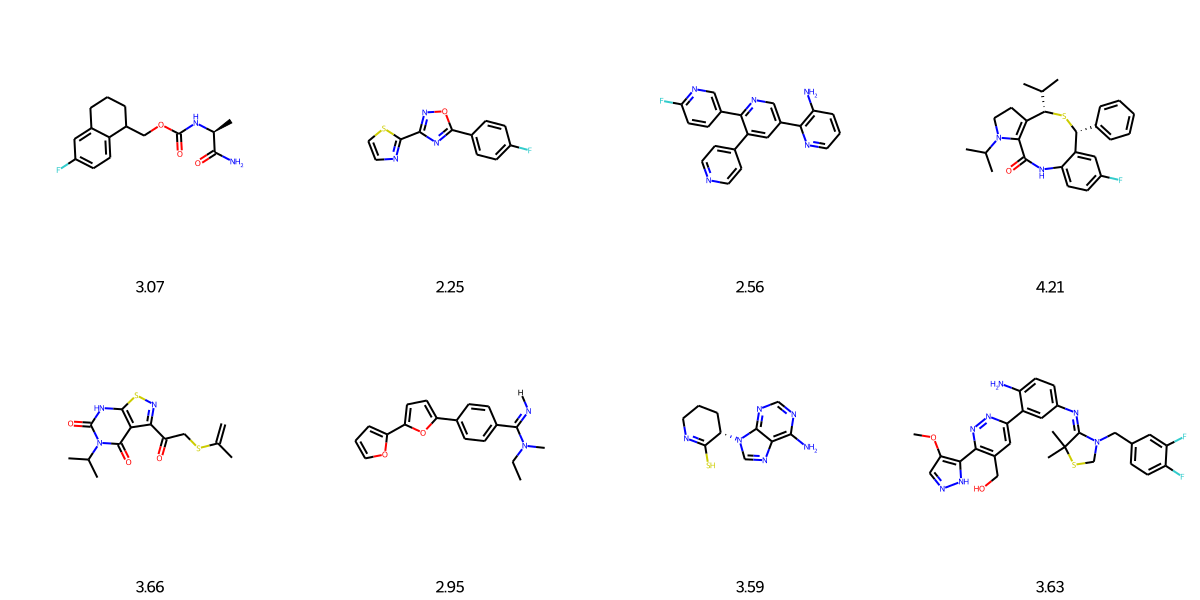

In [385]:
high_temp_image

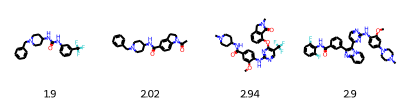

In [369]:
low_temp_image

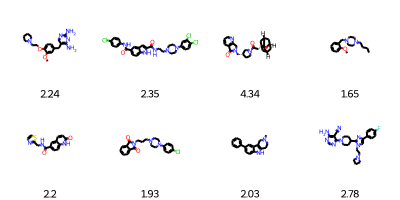

In [370]:
mid_temp_image

### Let's also compile the metrics from the xTB based validation

In [392]:
xtb_validation_metrics = [] 

for res in smiles_very_very_large_xtb_results:
    metrics = {
        'temperature': res['temperature'],
        'mae': res['mae'],
        'train_size': 50_000,
    }

    xtb_validation_metrics.append(metrics)

for res in smiles_very_large_xtb_results:
    metrics = {
        'temperature': res['temperature'],
        'mae': res['mae'],
        'train_size': 5_000,
    }

    xtb_validation_metrics.append(metrics)

for res in smiles_large_xtb_results:
    metrics = {
        'temperature': res['temperature'],
        'mae': res['mae'],
        'train_size': 1_000,
    }

    xtb_validation_metrics.append(metrics)

for res in smiles_small_xtb_results:
    metrics = {
        'temperature': res['temperature'],
        'mae': res['mae'],
        'train_size': 500,
    }

    xtb_validation_metrics.append(metrics)

In [393]:
xtb_validation_metrics = pd.DataFrame(xtb_validation_metrics)

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45
DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 187


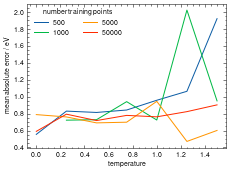

In [396]:
fig, ax = plt.subplots()
for train_size in [500, 1000, 5000, 50_000]:
    subset = xtb_validation_metrics[xtb_validation_metrics['train_size'] == train_size]
    ax.plot(subset['temperature'], subset['mae'], label=train_size)

ax.set_xlabel('temperature')
ax.set_ylabel('mean absolute error / eV')
ax.legend(title='number training points', ncol=2)
fig.tight_layout()
fig.savefig('20221130_xtb_validation_metrics.pdf', bbox_inches='tight')